## Feature Analysis on Train data

Please note that in this notebook we will use train sample only, it is important in case traget variable is also considered in analysis.

Why? If all existing data is used, then development set which further used to estimate the model is actualy can not be considered as `unseen`. Even though the model is trained on train data set, the decions on feature selection, cleaning procedures and etc may be derived from this kind of exploratoty analysis.

In [2]:
import os
import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import itertools

from dython.nominal import cramers_v, theils_u, correlation_ratio

In [3]:
save_path = '/Users/toma/Documents/Projects/taarifa-water-pumps/data/train_test_split'
X_train = pd.read_csv(os.path.join(save_path, 'x_train_split.csv'))
y_train = pd.read_csv(os.path.join(save_path, 'y_train_split.csv'), names=["status"])

In [4]:
X_train.shape

(47520, 34)

In [5]:
y_train.shape

(47520, 1)

In [6]:
X = pd.concat([X_train, y_train], axis=1)

In [7]:
X.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'month_recorded',
       'year_recorded', 'age_recorded', 'basin', 'region', 'lga',
       'public_meeting', 'recorded_by', 'scheme_management', 'permit',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status'],
      dtype='object')

In [8]:
X.sample(5)

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,month_recorded,year_recorded,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status
16185,0.0,0,31.640171,-1.851248,0,18,3,NaN,8,2011,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
39610,0.0,1437,30.874646,-3.140355,0,16,1,350.0,2,2013,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
40208,0.0,1175,32.879649,-1.934991,0,19,1,150.0,7,2011,...,soft,good,insufficient,insufficient,lake,river/lake,surface,communal standpipe multiple,communal standpipe,non functional
7487,0.0,0,32.427858,-3.309854,0,17,3,NaN,1,2013,...,milky,milky,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,functional
31779,0.0,0,30.483137,-2.621286,0,18,30,NaN,7,2011,...,soft,good,enough,enough,spring,spring,groundwater,other,other,functional


In [9]:
import seaborn as sns

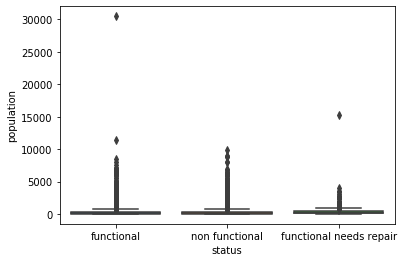

In [10]:
sns.boxplot(x="status", y="population", data=X.dropna())

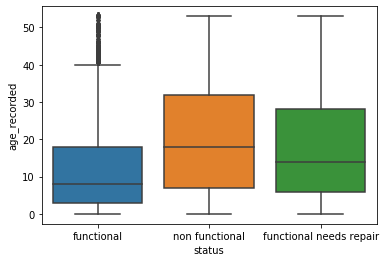

In [11]:
sns.boxplot(x="status", y="age_recorded", data=X.dropna())

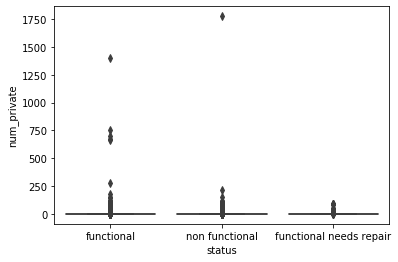

In [12]:
sns.boxplot(x="status", y="num_private", data=X.dropna())

In [13]:
X.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,month_recorded,year_recorded,age_recorded
count,47520.000000,47520.000000,47520.000000,4.752000e+04,47520.000000,47520.000000,47520.000000,30472.000000,47520.000000,47520.000000,31009.000000
mean,322.047573,668.745370,34.091316,-5.705002e+00,0.504566,15.326515,5.639310,279.967971,4.371296,2011.921843,15.353672
std,3200.623244,692.972153,6.538403,2.943503e+00,13.253850,17.618798,9.661285,566.079408,3.028894,0.958071,12.496698
min,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,1.000000,1.000000,2004.000000,0.000000
25%,0.000000,0.000000,33.084320,-8.532465e+00,0.000000,5.000000,2.000000,40.000000,2.000000,2011.000000,4.000000
50%,0.000000,370.000000,34.911677,-5.017697e+00,0.000000,12.000000,3.000000,150.000000,3.000000,2012.000000,13.000000
75%,20.000000,1320.000000,37.180585,-3.326464e+00,0.000000,17.000000,5.000000,320.000000,7.000000,2013.000000,25.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,12.000000,2013.000000,53.000000


## Categorical Features

For categorical variables I will consider two measures of assosiation:

Cramer's V - symmetrical measure of association between categorical variables, which is based on Pearson's Chi-squared statistic 
<br>https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test#Calculating_the_test-statistic
<br>https://en.wikipedia.org/wiki/P-value


Theil's U - non-symmetrical measure of association between categorical variables
<br>https://en.wikipedia.org/wiki/Uncertainty_coefficient

Why symmetry matters? It does matter because it may provide additional information about the relation between features, when one feature can predict another, but not the opposite. For example consider two features: payment and payment type. If we know that payment was by Visa card, then we know that paymet_type = 'credit/debit card', but knowing payment_type will not explain what card exactly was used. If in one geographical region most payments are made by card, then knowing the region we can predict the payment type, but from the knowledge of payment used we hardly can predict the region. Non semmetrical measure like Theil's U will distinguish these types of relations  

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47520 entries, 0 to 47519
Data columns (total 35 columns):
amount_tsh               47520 non-null float64
gps_height               47520 non-null int64
longitude                47520 non-null float64
latitude                 47520 non-null float64
num_private              47520 non-null int64
region_code              47520 non-null int64
district_code            47520 non-null int64
population               30472 non-null float64
month_recorded           47520 non-null int64
year_recorded            47520 non-null int64
age_recorded             31009 non-null float64
basin                    47520 non-null object
region                   47520 non-null object
lga                      47520 non-null object
public_meeting           44831 non-null object
recorded_by              47520 non-null object
scheme_management        44417 non-null object
permit                   45081 non-null object
extraction_type          47520 non-null object

In [15]:
categorical_features = list(X.select_dtypes(exclude=np.number).columns)

In [16]:
cat_desc = X[categorical_features].describe(include='all').transpose()[['count', 'unique', 'top']]
cat_desc["perc missing"] = (1 - cat_desc["count"]/X.shape[0]) * 100
cat_desc.sort_values('unique', ascending=False)

,count,unique,top,perc missing
lga,47520,125,Njombe,0
region,47520,21,Iringa,0
extraction_type,47520,18,gravity,0
extraction_type_group,47520,13,gravity,0
management,47520,12,vwc,0
scheme_management,44417,11,VWC,6.52988
source,47520,10,shallow well,0
basin,47520,9,Lake Victoria,0
water_quality,47520,8,soft,0
waterpoint_type,47520,7,communal standpipe,0


In [17]:
categorical_features.remove('recorded_by')

In [18]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [19]:
corrM = np.zeros((len(categorical_features),len(categorical_features)))
# for col1, col2 in itertools.product(categorical_features, repeat=2):
for col1, col2 in itertools.combinations(categorical_features, 2):
    idx1, idx2 = categorical_features.index(col1), categorical_features.index(col2)
    corrM[idx1, idx2] = cramers_v(X[col1], X[col2])
    corrM[idx2, idx1] = corrM[idx1, idx2]
    corrM[idx1, idx1] = 1



In [20]:
corr_thM = np.zeros((len(categorical_features),len(categorical_features)))
for col1, col2 in itertools.product(categorical_features, repeat=2):
    idx1, idx2 = categorical_features.index(col1), categorical_features.index(col2)
    corr_thM[idx1, idx2] = theils_u(X[col1], X[col2])


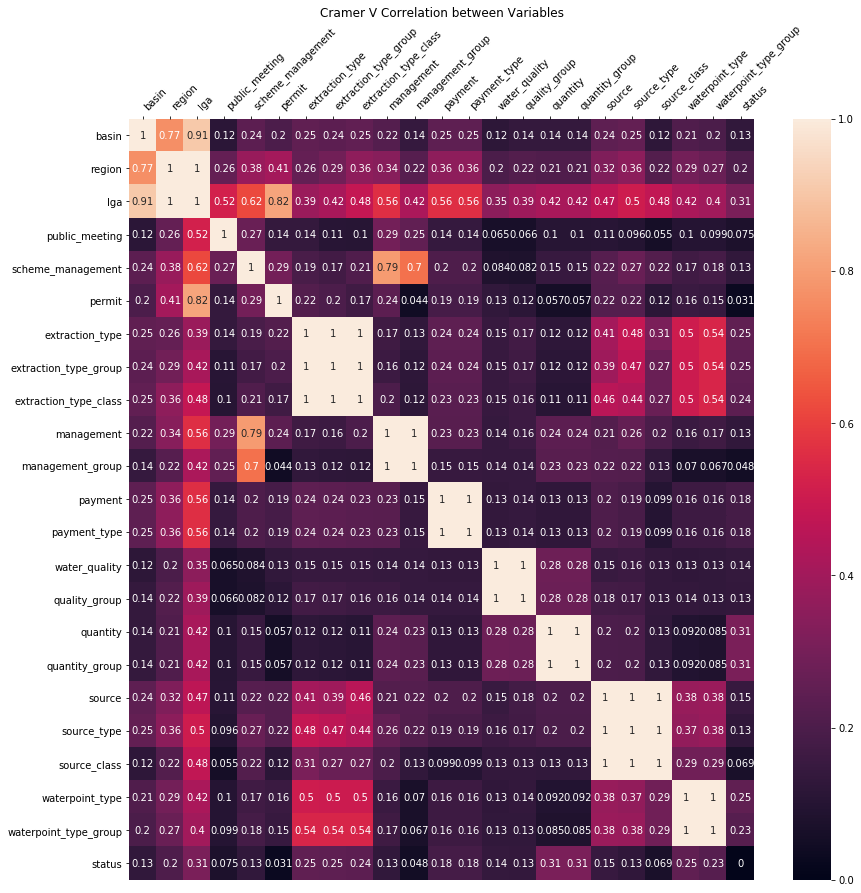

In [21]:
corr = pd.DataFrame(corrM, index=categorical_features, columns=categorical_features)
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corr, annot=True, ax=ax); 
ax.set_title("Cramer V Correlation between Variables")
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='left')
plt.show()

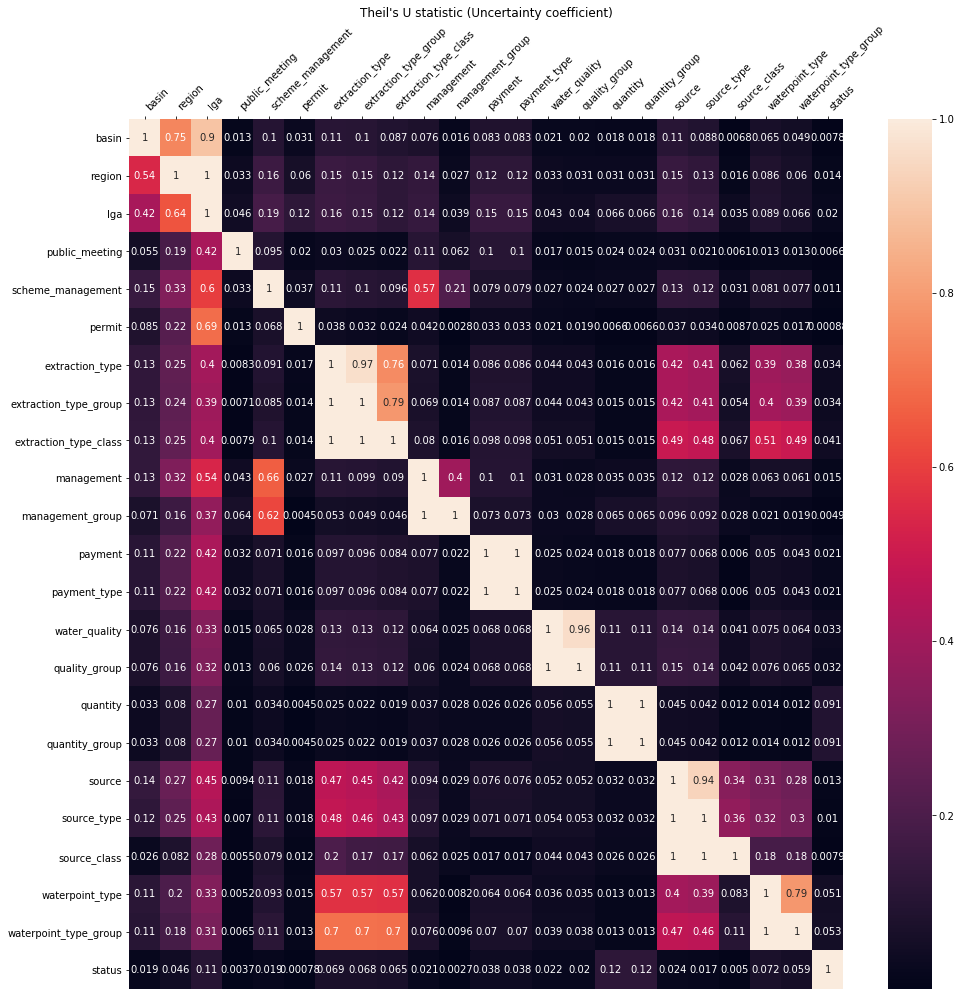

In [22]:
corr = pd.DataFrame(corr_thM, index=categorical_features, columns=categorical_features)
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corr, annot=True, ax=ax); 
ax.set_title("Theil's U statistic (Uncertainty coefficient)")
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='left')
plt.show()

So here we can the see the difference between symmetrical and non-symmetrical measures of assosiation, example of related variables: region and lga; extraction_type, extraction_type_group, extraction_type_class

In [23]:
cat_desc.loc[['region', 'lga'],: ]

,count,unique,top,perc missing
region,47520,21,Iringa,0
lga,47520,125,Njombe,0


In [24]:
cat_desc.loc[['extraction_type', 'extraction_type_group', 'extraction_type_class'],: ]

,count,unique,top,perc missing
extraction_type,47520,18,gravity,0
extraction_type_group,47520,13,gravity,0
extraction_type_class,47520,7,gravity,0


In [25]:
pd.crosstab(X['extraction_type_class'], X['extraction_type_group'] )

extraction_type_group,afridev,gravity,india mark ii,india mark iii,mono,nira/tanira,other,other handpump,other motorpump,rope pump,submersible,swn 80,wind-powered
extraction_type_class,,,,,,,,,,,,,
gravity,0,21340,0,0,0,0,0,0,0,0,0,0,0
handpump,1409,0,1920,71,0,6566,0,291,0,0,0,2965,0
motorpump,0,0,0,0,2284,0,0,0,102,0,0,0,0
other,0,0,0,0,0,0,5150,0,0,0,0,0,0
rope pump,0,0,0,0,0,0,0,0,0,376,0,0,0
submersible,0,0,0,0,0,0,0,0,0,0,4962,0,0
wind-powered,0,0,0,0,0,0,0,0,0,0,0,0,84


In [26]:
cat_desc.loc[['lga', 'basin'],: ]

,count,unique,top,perc missing
lga,47520,125,Njombe,0
basin,47520,9,Lake Victoria,0


In [27]:
cat_desc.loc[['management', 'scheme_management'],: ]

,count,unique,top,perc missing
management,47520,12,vwc,0
scheme_management,44417,11,VWC,6.52988


In [28]:
pd.crosstab(X['management'], X['scheme_management'])

scheme_management,Company,Other,Parastatal,Private operator,SWC,Trust,VWC,WUA,WUG,Water Board,Water authority
management,,,,,,,,,,,
company,514,0,0,2,0,0,2,1,4,0,0
other,1,427,0,3,0,0,37,1,13,18,40
other - school,0,0,0,0,70,0,11,0,0,0,0
parastatal,16,1,1253,3,0,1,99,25,5,1,0
private operator,182,47,51,779,0,1,123,151,5,2,140
trust,0,1,0,1,0,48,2,0,0,2,8
unknown,0,7,3,0,0,0,60,0,4,0,0
vwc,106,34,38,69,5,4,28350,196,325,323,1045
water authority,0,12,0,3,0,1,7,0,0,1,690


In [29]:
(X.permit == 'yes').mean()

0.6529461279461279

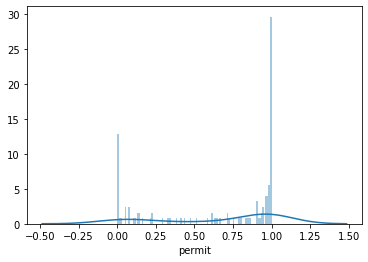

In [30]:
sns.distplot(X.groupby('lga').permit.apply(lambda s: (s=='yes').mean()), bins=100)

## Correlation of Continious variables

In [31]:
X.select_dtypes(include=np.number).sample(5)

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,month_recorded,year_recorded,age_recorded
38041,0.0,0,36.194481,-6.154019,0,1,4,NaN,3,2011,NaN
5718,200.0,2135,33.996586,-9.276178,0,11,3,NaN,3,2011,28.0
13638,100.0,737,36.737208,-7.349801,0,5,1,150.0,3,2011,1.0
2798,500.0,2032,34.676386,-9.331753,0,11,4,100.0,3,2011,3.0
42100,0.0,1661,34.874248,-4.897300,0,13,2,1.0,1,2013,43.0


In [32]:
numeric_features = [c for c in X.select_dtypes(include=np.number).columns if c not in
                    ['region_code', 'district_code', 'month_recorded', 'year_recorded']] 


In [33]:
X[numeric_features].corr()

,amount_tsh,gps_height,longitude,latitude,num_private,population,age_recorded
amount_tsh,1.000000,0.073334,0.020588,-0.049646,0.003600,-0.000810,-0.006846
gps_height,0.073334,1.000000,0.147360,-0.036383,0.007864,-0.043530,0.019479
longitude,0.020588,0.147360,1.000000,-0.425200,0.023393,-0.097179,-0.034918
latitude,-0.049646,-0.036383,-0.425200,1.000000,0.009438,0.048344,-0.019140
num_private,0.003600,0.007864,0.023393,0.009438,1.000000,-0.004749,0.001158
population,-0.000810,-0.043530,-0.097179,0.048344,-0.004749,1.000000,-0.027987
age_recorded,-0.006846,0.019479,-0.034918,-0.019140,0.001158,-0.027987,1.000000


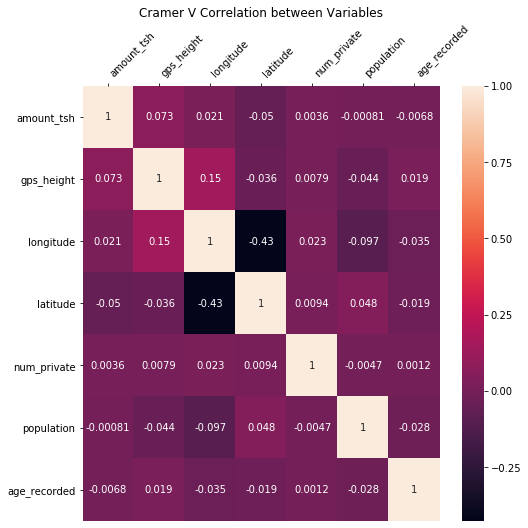

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(X[numeric_features].corr(), annot=True, ax=ax); 
ax.set_title("Cramer V Correlation between Variables")
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='left')
plt.show()

## The Whole Picture of Feature Correlations

Now we checked the assosiation between numerical and categorical varibales. If we could measure the relation between categorical and numerical, then we could see the global picture of all feature relations. We can do it using Correlation Ratio  https://en.wikipedia.org/wiki/Correlation_ratio

I will use `dython` library, which actually inspired this analysis, and build the heatmap for all feature assosiations. 

In [35]:
from dython.nominal import associations

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


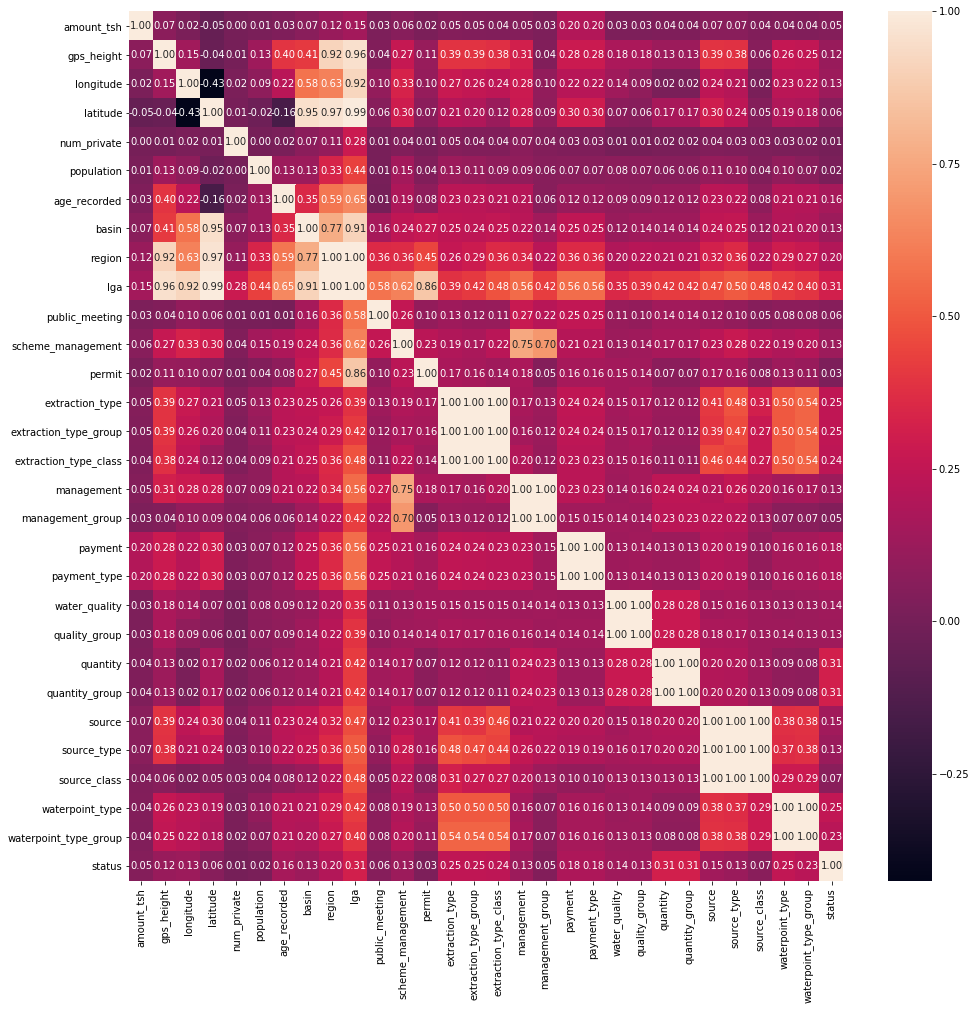

In [36]:
associations(X[numeric_features+categorical_features], nominal_columns=categorical_features,
            figsize=(16,16))

lga - local government authority

We see correlation between region, basin and geo variables which is of course something one would expect.

As for the correlation with the target variable `status` the highes are among quantity,  quantity_group, lga. 

In [37]:
cat_desc.loc['lga',:]

count            47520
unique             125
top             Njombe
perc missing         0
Name: lga, dtype: object

## Location Variables and Geo Outliers

The following bounds I took from Open Street map to get the bound of Tanzania area, the picture used below was also extracted from this maps using these bounds

Later we will see that some values of longitude and latitude are outliers for Tanzania region, and as an additional confirmation all outliers are the same value which may be a sign of typo error or non-standard missing value.

In [39]:
min_long = 28.633
max_long =41.275
min_lat = -11.740
max_lat =  -0.874

In [40]:
BBox = (min_long,   max_long,      
         min_lat, max_lat)

In [42]:
ruh_m = plt.imread('/Users/toma/Documents/Projects/taarifa-water-pumps/data/map.png')

In [43]:
X.loc[X.longitude==0, 'lga'].value_counts()

Bariadi    806
Geita      380
Magu       247
Name: lga, dtype: int64

In [44]:
X.query('longitude < @min_long').longitude.describe()

count    1433.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: longitude, dtype: float64

In [45]:
X.query('longitude > @max_long').shape

(0, 35)

In [46]:
X.query('latitude < @min_lat or latitude > @max_lat').shape

(1433, 35)

In [47]:
geo_outl = 'longitude > @max_long or longitude < @min_long or latitude < @min_lat or latitude > @max_lat'
geo_notoutl = 'longitude < @max_long and longitude > @min_long and latitude > @min_lat and latitude < @max_lat'

In [48]:
X.query(geo_outl).shape

(1433, 35)

In [49]:
X.query(geo_outl)[['latitude', 'longitude']].describe()

,latitude,longitude
count,1.433000e+03,1433.0
mean,-2.000000e-08,0.0
std,1.787334e-22,0.0
min,-2.000000e-08,0.0
25%,-2.000000e-08,0.0
50%,-2.000000e-08,0.0
75%,-2.000000e-08,0.0
max,-2.000000e-08,0.0


In [50]:
X.query(geo_outl).lga.value_counts()

Bariadi    806
Geita      380
Magu       247
Name: lga, dtype: int64

In [51]:
X.query('lga=="Geita"')[['latitude', 'longitude']].drop_duplicates()

,latitude,longitude
190,-2.000000e-08,0.0


In [52]:
(X.longitude == 0).sum()

1433

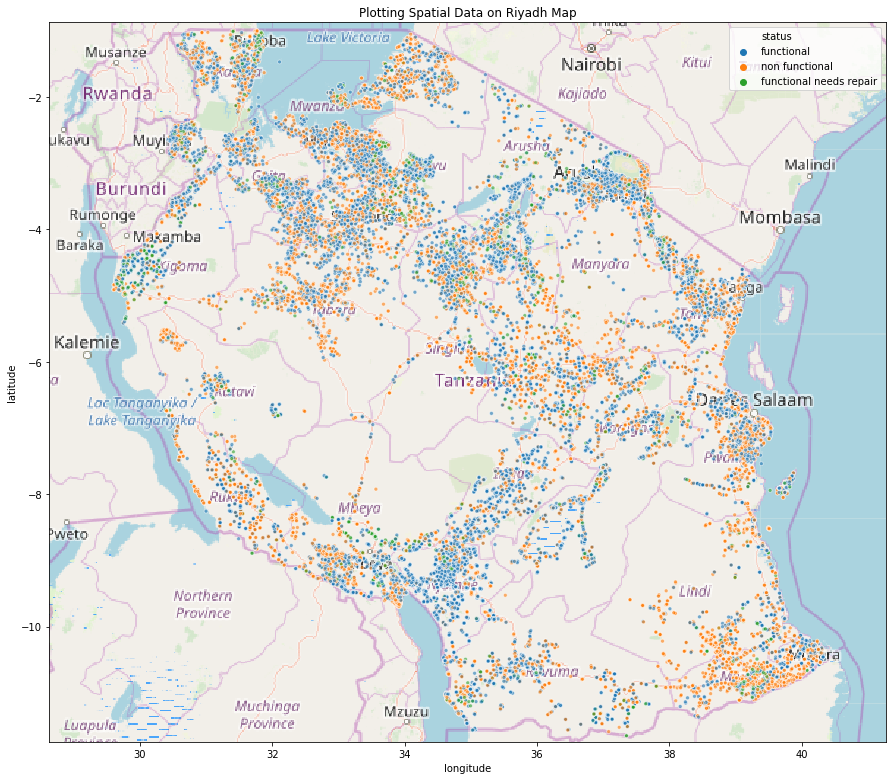

In [53]:
fig, ax = plt.subplots(figsize = (15,15))
# ax.scatter(X.query(geo_notoutl).longitude, X.query(geo_notoutl).latitude, zorder=1, alpha= 0.2, c='b', s=10)
sns.scatterplot(x="longitude", y="latitude",
                      hue="status",  data=X.query(geo_notoutl), ax=ax, s=15, alpha=0.6)


ax.set_title('Plotting Spatial Data on Riyadh Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

## References

https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

https://github.com/shakedzy/dython/blob/master/dython/nominal.py